In [ ]:
import time
import tqdm
import random
from typing import List
import itertools as it
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cobyla

from mindquantum.core.operators import QubitOperator
from mindquantum.core.operators import Hamiltonian
from mindquantum.simulator import Simulator
from mindquantum import H, X, Z, RY, UN, CNOT, Circuit
import mindspore.context as context

context.set_context(mode=context.PYNATIVE_MODE, device_target="CPU")

## 1. 数据集

整个训练过程和机器学习一致，首先应准备数据集，然后使用 VQA 训练网络参数。

根据论文，将论文 [1][Francesco Scala, etc. Quantum variational learning for entanglement witnessing] 中 `A. Exact witness computation` 识别出的纠缠态（共18个，对应图5中高于红线以上的态）对应的标签为 1，其余将可分离（bi-separable）状态（对应图5中橙色线）的前一半的标签设为 0，另外将为未识别出来的纠缠态的前一半再取 60% 的标签设为 0. 取一半的原因是因为数据具有对称性。

此处将获取可分离态、获取识别纠缠态等用代码复现。

### 1.1 Bi-separable states

通过逐一列举，获取 3-bits 系统中所有可以分为两个子系统的态。由于 REW 态是所有状态等权重混合，只有每个成分前面的正负号不同，对于3比特的 REW 态，共有8个成分，因此将每个成分前面的符号拿出来共有 2^8 = 256 种组合，因此用数值 0-255 表示。在代码中，负号用 1 代替，正号用 0 代替，这样可以形成01的二进制串，转换成10进制即为0-255之间的数值。

In [2]:
def get_separable_states() -> List:
    """Get all 3-bits bi-separable states and represented by digit that
    range from 0 to 255"""
    pm1bit = list(it.product([-1, 1], repeat=2))
    pm2bit = list(it.product([-1, 1], repeat=4))
    pm3bit = np.array([np.kron(a, b) for a in pm1bit for b in pm2bit])
    str1bit = ['0', '1']
    str2bit = ['00', '01', '10', '11']
    strs1 = [a + b for a in str1bit for b in str2bit]
    strs2 = [b + a for a in str1bit for b in str2bit]
    strs3 = [b[0] + a + b[1] for a in str1bit for b in str2bit]
    strs4 = [b[1] + a + b[0] for a in str1bit for b in str2bit]
    strs3bit = [strs1, strs2, strs3, strs4]
    sep_digits = []
    for strs in strs3bit:
        for pm in pm3bit:
            # sorted to make the string in the order of: |0>, |1>,..., |7>
            pm_strs = sorted(zip(pm, strs), key=lambda x: x[1])
            # map {-1, 1} to {0, 1}
            pm, _ = zip(*pm_strs)
            pm = np.array(pm)
            pm[pm == -1] = 0  # change -1 to 0
            i = (np.array(pm) * np.array([128, 64, 32, 16, 8, 4, 2, 1])).sum()
            sep_digits.append(i)
    sep_digits = sorted(list(set(sep_digits)))
    return sep_digits

### 1.2 Recognized entangled states

取参考态 $|H>=[0, 0, 0, 0, 0, 1, 1, 0]$，计算各个态与参考态的激活值，激活值也相当于 overlap 或 fidelity, 其值为 $Tr[\rho |H><H|]$ 。如果高于阈值（文中取 0.5），即为识别出来的可分离态。由于激活值的两个态只是 REW 前面的符号不同，因此使用异或运算等计算激活值。

In [3]:
def get_overlap(fx: List, ref: List, n=3) -> float:
    """Get overlap between `fx` and `ref`.

    Args:
        fx: The input state to calculate the overlap (fidelity).
        ref: The reference state.
        n: number of qubits.

    Return:
        act: The overlap value, which is called overlap or fidelity as well.
    """
    xor = np.array(list(map(lambda x, y: x ^ y, fx, ref)))
    act = np.abs(((-1)**xor).sum()) / 2**n
    return act


def get_recognized_entangled_states():
    """Get recognized entangled states.
    """
    n = 3                                     # number of qubits
    ref = [0, 0, 0, 0, 0, 1, 1, 0]            # reference states
    fxs = list(it.product([0, 1], repeat=8))  # all states
    rec_ent_states = []
    for fx in fxs:
        v = get_overlap(fx, ref, n)
        if v > 0.5:
            rec_ent_states.append(
                (np.array(fx) * np.array([128, 64, 32, 16, 8, 4, 2, 1]))
                .sum()
            )
    return rec_ent_states

### 1.3 训练数据

In [4]:
def prepare_training_data():
    """Prepare the training data.
    """
    # bi-separable states
    sep_states = get_separable_states()
    # recognized entangled states
    rec_ent_states = get_recognized_entangled_states()
    # unrecognized entangled states
    unrec_ent_states = list(
        set(range(256)) - set(sep_states) - set(rec_ent_states)
    )
    # split the train data according to the proportion in paper.
    half_fun = lambda x: x <= 127
    x0 = list(filter(half_fun, sep_states))
    x0 += random.sample(list(filter(half_fun, unrec_ent_states)),
                        int(256 / 2 * 0.6))
    y0 = [0] * len(x0)
    x1 = rec_ent_states
    y1 = [1] * len(x1)
    x = x0 + x1
    y = y0 + y1
    return (x, y)

## 2. 量子线路

量子线路主要包括编码器（Encoder）线路和 ansatz，编码器及将 REW 态转换成量子线路实现，使用论文[2][M. Rossi, M. Huber, D. Bruß, et al. Quantum hypergraph states] 提出的方法实现编码器。 ansatz 比较简单，直接按照论文[1] Fig.2 实现即可。

### 2.1 Encoder

In [5]:
def int2signs(i: int) -> List:
    """Convert a integral to a 8-bits sign array, such as 11=|0000 0111>,
    map 1 to -1, map 0 to 1, so the result is [1, 1, 1, 1, 1, -1, -1, -1];

    Args:
        i: the input integral.
    Return:
        signs: the sign array corresponding to the `i`.
    """
    signs = []
    for _ in range(8):
        tmp = -1 if i % 2 else 1
        signs.insert(0, tmp)
        i = i // 2
    return signs


def get_operation(signs: List) -> List:
    """Generate the operations according to `signs`, these rules refers to
    paper: M. Rossi, M. Huber, D. Bruß, et al. Quantum hypergraph states.

    Args:
        signs: the signs of REW states, a array with 8 bits and composed of -1 or 1.

    Return:
        ops: The qubits that Z(controlled-Z) gates apply to.
    """
    ops = []
    signs = np.array(signs)
    if signs[0] == -1:
        signs = -signs
    if signs[1] == -1:
        signs[[1, 3, 5, 7]] *= -1
        ops.append((0,))
    if signs[2] == -1:
        signs[[2, 3, 6, 7]] *= -1
        ops.append((1,))
    if signs[4] == -1:
        signs[[4, 5, 6, 7]] *= -1
        ops.append((2,))
    if signs[3] == -1:
        signs[[3, 7]] *= -1
        ops.append((0, 1))
    if signs[5] == -1:
        signs[[5, 7]] *= -1
        ops.append((0, 2))
    if signs[6] == -1:
        signs[[6, 7]] *= -1
        ops.append((1, 2))
    if signs[7] == -1:
        signs[7] *= -1
        ops.append((0, 1, 2))
    return ops


def prepare_states_circuit(ops: List) -> Circuit:
    """Prepare REW states circuit.

    Args:
        ops: The operations that prepare the circuit.

    Return:
        cir: The quantum circuit to prepare the state corresponding to `ops`.
    """
    cir = Circuit()
    cir += UN(H, [0, 1, 2])
    for op in ops:
        cir += Z.on(op[0], op[1:])
    return cir


def get_encoder(i: int) -> Circuit:
    """Get the encoder circuit corresponding to `i`.

    Args:
        i: The data, which means the signs of a REW state.

    Return:
        cir: The circuit to prepare the state of determined by `i`.
    """
    signs = int2signs(i)
    ops = get_operation(signs)
    cir = prepare_states_circuit(ops)
    return cir

### 2.2 Ansatz

In [6]:
def get_ansatz():
    """Prepare the ansatz proposed in paper: Francesco Scala et al.
    Quantum variational learning for entanglement witnessing.
    """
    ansatz = Circuit([
        RY('theta0').on(0),
        RY('theta1').on(1),
        RY('theta2').on(2),
        CNOT(1, 0),
        CNOT(2, 0),
        CNOT(2, 1),
        RY('theta3').on(0),
        RY('theta4').on(1),
        RY('theta5').on(2),
        CNOT(1, 0),
        CNOT(2, 0),
        CNOT(2, 1),
        RY('theta6').on(0),
        RY('theta7').on(1),
        RY('theta8').on(2),
    ])
    return ansatz

### 2.3 Full circuit

In [7]:
def get_full_circuit(i: int) -> Circuit:
    """Get the full circuit with initial state is `i`.
    """
    encoder = get_encoder(i)
    ansatz = get_ansatz()
    cir = encoder + ansatz
    cir += X(3, [0, 1, 2])
    return cir

## 3. 训练与验证

方法一：使用梯度下降法（gradient descent）训练网络参数，由于使用单个样本训练最后容易受单个参数影响，因此使用多个数据同时计算梯度累加，减少误差。另外使得学习率不断变小，避免震荡。在计算损失时，由于bi-seperable的标签为 $0$，其余标签为 $1$，使用 $Z3$ 做哈密顿量测量第4个量子比特的期望值（取值范围为 $[-1, 1]$）。采用交叉熵损失，具体做法为在梯度求解中根据期望值求得的变量梯度计算交叉熵损失下的变量梯度。由于正负样本不平衡，对较少样本损失乘以一定权重（代码中取 $10$），为了避免梯度太大等造成误差，将梯度使用 `clip` 函数截断。

In [9]:
def train_gd():
    n_qubits = 4     # number of qubits
    batch_size = 16  # batch size
    lr = 0.02        # learning rate
    decay = 0.99     # learning rate decay
    n_iter = 300     # number of iteration

    sim = Simulator('projectq', n_qubits)
    ham = Hamiltonian(QubitOperator('Z3'))
    weight = np.array([0] * 9, dtype=np.float32)
    x, y = prepare_training_data()

    for _ in tqdm.tqdm(range(n_iter)):
        grad = np.zeros_like(weight)
        for _ in range(batch_size):
            xi, yi = random.choice(list(zip(x, y)))
            cir = get_full_circuit(xi)
            grad_ops = sim.get_expectation_with_grad(ham, cir)
            f, g = grad_ops(weight)
            p = np.real((1.0 + f[0, 0]) / 2.)
            g = np.real(g.ravel())
            g0 = yi / 2 / p * g
            g1 = -(1 - yi) / 2 / (1 - p) * g
            g0 = np.clip(10.0 * g0, -20, 20)
            g1 = np.clip(g1, -20, 20)
            grad += g0 + g1
        weight -= lr * grad
        lr *= decay
    return weight

方法二：基于所给数据进行训练，按照论文中使用交叉熵作为损失函数，使用 COBYLA 优化器更新参数。调用 `scipy` 库的优化函数 `fmin_cobyla`。验证时将各个 REW 态输入，查看网络判别结果。

In [10]:
def train_cobyla():
    """Train the network with COBYLA optimizer to optimize the parameters.
    """
    def objective(pr):
        """The objective function.
        """
        v = 0.0
        for xi, yi in zip(x, y):
            cir = get_full_circuit(xi)
            qs = cir.get_qs(pr=pr)
            pi = np.abs(qs[-1]**2).sum()
            v -= yi * np.log(pi) + (1 - yi) * np.log(1 - pi)
        return v

    x, y = prepare_training_data()
    print(f"Finish preparing data, with {len(x)} items.")
    params = np.random.uniform(size=9)
    print("Begin training, it may take several minutes on cpu.")
    best_pr = fmin_cobyla(objective, params, cons=[])
    print(f"Finish training, the best parameters are:\n{best_pr}.\n")
    return best_pr

验证和可视化代码：

In [11]:
def validate_and_visualize(best_pr, save_path="fig5.png"):
    """Validate the result and plot Fig. 5, which from the paper.

    Args:
        best_pr: The trained parameters.
    """
    acts = []
    for i in range(256):
        cir = get_full_circuit(i)
        qs = cir.get_qs(pr=best_pr)
        acts.append(np.abs(qs[-1]**2).sum())
    # seprable states
    sep_states = get_separable_states()
    sep_values = np.array(acts)[sep_states]
    plt.figure(figsize=(12, 5))
    plt.bar(range(256), acts, color='cyan', width=1.0)
    plt.bar(sep_states, sep_values, color='orange', width=1.0)
    plt.plot([0, 255], [0.5, 0.5], color='red')
    plt.xlabel("Hypergraph states")
    plt.ylabel("Activation")
    plt.savefig(save_path)
    print(f"The result image has been save at: {save_path}")
    plt.show()

## 4. 运行验证

对使用梯度下降法和COBYLA方法均进行验证。可以看到其输出结果与论文[1] Fig.5 基本一致。取阈值为 0.5，在 256 个态中，所有可分离态（64个）被正确识别，192个纠缠态中有 18 个纠缠态被正确识别。

100%|██████████| 300/300 [04:26<00:00,  1.13it/s]


The result image has been save at: fig5.png


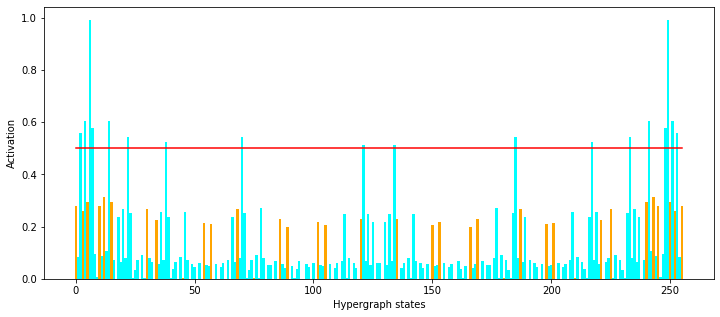

It spends 4.56 minutes.
END


In [12]:
def run():
    t1 = time.time()
    # 使用梯度下降法
    best_pr = train_gd()
    validate_and_visualize(best_pr)
    t2 = time.time()
    print("It spends {:.2f} minutes.\nEND".format((t2 - t1)/60))


run()

Finish preparing data, with 126 items.
Begin training, it may take several minutes on cpu.
Finish training, the best parameters are:
[ 1.52680435  1.62056776 -0.03166083  1.53614936  0.01427009 -0.31209835
  0.09543332  0.01496778  0.29417818].

The result image has been save at: fig5.png


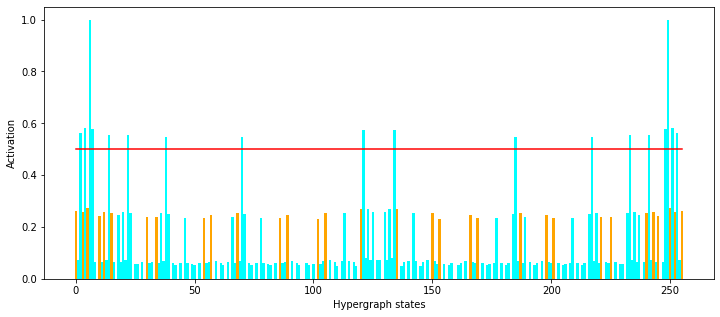

It spends 8.17 minutes.
END


In [13]:
def run2():
    t1 = time.time()
    # 使用 cobyla 优化器
    best_pr = train_cobyla()
    validate_and_visualize(best_pr)
    t2 = time.time()
    print("It spends {:.2f} minutes.\nEND".format((t2 - t1)/60))


run2()

验证结果表明：使用 COBYLA 优化器对识别出的纠缠态具有较大激活值（Activation）并数值差异较小，较为稳定，更具鲁棒性。